<a href="https://colab.research.google.com/github/hrishi508/Self-and-Semi-Supervised-Learning/blob/main/Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import time
import numpy as np
import matplotlib.pyplot as plt

In [18]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data Preparation

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15)
])

training_data = datasets.STL10(
    root="data",
    split="train",
    transform=transform,
    download=False
)

test_data = datasets.STL10(
    root="data",
    split='test',
    transform=transform,
    download=False
)

In [21]:
## HYPERPARAMETERS
BATCH_SIZE = 64
LR = 0.001
EPOCHS = 100

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
def imshow(img):
    t1 = torch.tensor([0.485, 0.456, 0.406])
    t2 = torch.tensor([0.229, 0.224, 0.225])
    img[0]*=t2[0]
    img[1]*=t2[1]
    img[2]*=t2[2]

    img[0]+=t1[0]
    img[1]+=t1[1]
    img[2]+=t1[2]

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

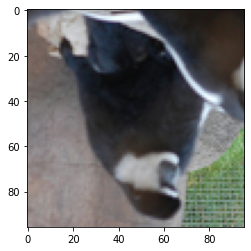

monkey
torch.Size([3, 96, 96])


In [23]:
labels_map = {
    0: "airplane",
    1: "bird",
    2: "car",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "horse",
    7: "monkey",
    8: "ship",
    9: "truck",
}
img, label = training_data[155]
imshow(img)
print(labels_map[label])
print(img.shape)

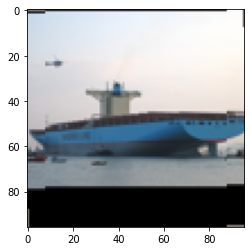

ship


In [24]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0]
imshow(img)
print(labels_map[train_labels[0].item()])

## Train and Test functions

In [25]:
def train_model(model, dataloader, loss_func, optimizer, num_epochs = EPOCHS):
    since = time.time()
    model = model.to(device)
    model.train()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)        

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):                    
                outputs = model(inputs)
                outputs = outputs.to(device)
                loss = loss_func(outputs, labels)

                _, preds = torch.max(outputs, 1)
                
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return

In [26]:
def test(model):
  corrects = 0
  total = 0

  for X,y in test_dataloader:
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
      _, predicted = torch.max(y_pred.data, 1)
      total += y.size(0)
      corrects += (predicted == y).sum().item()

  print(f"Accuracy of the model : {(float(corrects)/total)*100}%")

## ResNet 9 Model

In [27]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                nn.BatchNorm2d(out_channels), 
                nn.ReLU(inplace=True)
              ]

    if pool: 
      layers.append(nn.MaxPool2d(2))
    
    return nn.Sequential(*layers)

class ResNet9(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(ResNet9, self).__init__()
        
        self.conv1 = conv_block(in_channels, 64,pool=True)
        self.conv2 = conv_block(64, 128, pool=True) 
        self.res1 = nn.Sequential(conv_block(128, 128), 
                                  conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), 
                                  conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [28]:
model = ResNet9(3, 10)
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

### Debug Block

In [29]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv_layer = nn.Sequential(

#             # Conv Layer block 1
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=0),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Conv Layer block 2
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=0),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=0),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout2d(p=0.06),

#             # Conv Layer block 3
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=0),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=0),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )


#         self.fc_layer = nn.Sequential(
#             nn.Dropout(p=0.15),
#             nn.Linear(6400, 1024),
#             nn.ReLU(inplace=True),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.15),
#             nn.Linear(512, 10),
#         )


#     def forward(self, x):        
#         # conv layers
#         x = self.conv_layer(x)
        
#         # flatten
#         x = x.view(x.size(0), -1)
        
#         # fc layer
#         x = self.fc_layer(x)

#         return x

## Training

In [30]:
train_model(model, train_dataloader, loss_fn, optimizer)

Epoch 0/99
----------
Loss: 2.1033 Acc: 0.2914

Epoch 1/99
----------
Loss: 1.6684 Acc: 0.3878

Epoch 2/99
----------
Loss: 1.5417 Acc: 0.4322

Epoch 3/99
----------
Loss: 1.4719 Acc: 0.4670

Epoch 4/99
----------
Loss: 1.3247 Acc: 0.5132

Epoch 5/99
----------
Loss: 1.2427 Acc: 0.5382

Epoch 6/99
----------
Loss: 1.1958 Acc: 0.5586

Epoch 7/99
----------
Loss: 1.1285 Acc: 0.5800

Epoch 8/99
----------
Loss: 1.0918 Acc: 0.5932

Epoch 9/99
----------
Loss: 1.0265 Acc: 0.6280

Epoch 10/99
----------
Loss: 1.0044 Acc: 0.6390

Epoch 11/99
----------
Loss: 0.9957 Acc: 0.6372

Epoch 12/99
----------
Loss: 0.9464 Acc: 0.6458

Epoch 13/99
----------
Loss: 0.9019 Acc: 0.6704

Epoch 14/99
----------
Loss: 0.9192 Acc: 0.6692

Epoch 15/99
----------
Loss: 0.8515 Acc: 0.6850

Epoch 16/99
----------
Loss: 0.8588 Acc: 0.6856

Epoch 17/99
----------
Loss: 0.8144 Acc: 0.7048

Epoch 18/99
----------
Loss: 0.7800 Acc: 0.7136

Epoch 19/99
----------
Loss: 0.7940 Acc: 0.7100

Epoch 20/99
----------
Loss: 0

In [31]:
# model.load_state_dict(torch.load("/content/drive/MyDrive/data/weights_stl10.pth", map_location=torch.device(device)))

In [32]:
test(model)

Accuracy of the model : 73.32499999999999%


In [33]:
torch.save(model.state_dict(), '/content/drive/MyDrive/data/weights_stl10_supervised_final.pth')